<a href="https://colab.research.google.com/github/enakai00/rl_book_solutions/blob/master/Chapter06/SARSA_vs_Q_Learning_vs_MC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy as np
from numpy import random
from pandas import DataFrame
import copy

In [0]:
class Car:
  def __init__(self):
    self.path = []
    self.actions = [(0, 1), (1, 0), (0, -1), (-1, 0)]
    self.episodes = [0]
    self.q = {}
    self.c ={}
    self.restart()

  def restart(self):
    self.x, self.y = 0, 3
    self.path = []

  def get_state(self):
    return self.x, self.y

  def show_path(self):
    result = [[' ' for x in range(10)] for y in range(7)]
    for c, (x, y, a) in enumerate(self.path):
      result[y][x] = str(c)[-1]
    result[3][7] = 'G'
    return result     

  def add_episode(self, c=0):
    self.episodes.append(self.episodes[-1]+c)

  def move(self, action):
    self.path.append((self.x, self.y, action))
    vx, vy = self.actions[action]
    if self.x >= 3 and self.x <= 8:
      vy -= 1
    if self.x >= 6 and self.x <= 7:
      vy -= 1

    _x, _y = self.x + vx, self.y + vy
    if _x < 0 or _x > 9:
      _x = self.x
    if _y < 0 or _y > 6:
      _y = self.y
    self.x, self.y = _x, _y
    if (self.x, self.y) == (7, 3): # Finish
      return True

    return False

In [0]:
def get_action(car, epsilon, default_q=0):
  if random.random() < epsilon:
    a = random.randint(0, len(car.actions))
  else:
    a = optimal_action(car, default_q)
  return a

def optimal_action(car, default_q=0):
  optimal = 0
  q_max = 0
  initial = True
  x, y = car.get_state()
  for a in range(len(car.actions)):
    sa = "{:02},{:02}:{:02}".format(x, y, a)
    if sa not in car.q.keys():
      car.q[sa] = default_q
    if initial or car.q[sa] > q_max:
      q_max = car.q[sa]
      optimal = a
      initial = False
  return optimal

def update_q(car, x, y, a, epsilon, q_learning=False):
  sa = "{:02},{:02}:{:02}".format(x, y, a)
  if q_learning:
    _a = optimal_action(car)
  else:
    _a = get_action(car, epsilon)
  _x, _y = car.get_state()
  sa_next = "{:02},{:02}:{:02}".format(_x, _y, _a)

  if sa not in car.q.keys():
    car.q[sa] = 0
  if sa_next not in car.q.keys():
    car.q[sa_next] = 0

  car.q[sa] += 0.5 * (-1 + car.q[sa_next] - car.q[sa])
  if q_learning:
    _a = get_action(car, epsilon)

  return _a

def trial(car, epsilon = 0.1, q_learning=False):
  car.restart()
  a = get_action(car, epsilon)
  while True:
    x, y = car.get_state()
    finished = car.move(a)
    if finished:
      car.add_episode(1)
      sa = "{:02},{:02}:{:02}".format(x, y, a)
      if sa not in car.q.keys():
        car.q[sa] = 0
      car.q[sa] += 0.5 * (-1 + 0 - car.q[sa])
      break
    a = update_q(car, x, y, a, epsilon, q_learning)
    car.add_episode(0)

In [0]:
def trial_mc(car, epsilon=0.1):
  car.restart()
  while True:
    x, y = car.get_state()
    state = "{:02},{:02}".format(x, y)
    a = get_action(car, epsilon, default_q=-10**10)
    finished = car.move(a)
    if finished:
      car.add_episode(1)
      g = 0
      w = 1
      path = copy.copy(car.path)
      path.reverse()
      for x, y, a in path:
        car.x, car.y = x, y
        opt_a = optimal_action(car, default_q=-10**10)
  
        sa = "{:02},{:02}:{:02}".format(x, y, a)
        g += -1 # Reward = -1 for each step
        if sa not in car.c.keys():
          car.c[sa] = w
          car.q[sa] = g
        else:
          car.c[sa] += w
          car.q[sa] += w*(g-car.q[sa])/car.c[sa]
        if opt_a != a:
          break
        w = w / (1 - epsilon + epsilon/len(car.actions))

      break
    car.add_episode(0)

In [5]:
car1, car2, car3 = Car(), Car(), Car()
while True:
  trial(car1)
  if len(car1.episodes) >= 10000:
    break
print(car1.episodes[-1])

while True:
  trial(car2, q_learning=True)
  if len(car2.episodes) >= 10000:
    break
print(car2.episodes[-1])

while True:
  trial_mc(car3)
  if len(car3.episodes) >= 200000:
    break
print(car3.episodes[-1])

235
316
5585


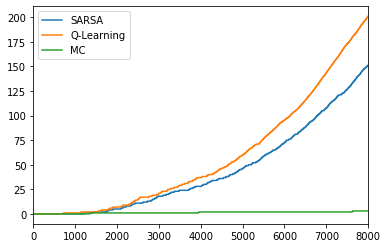

In [6]:
DataFrame({'SARSA': car1.episodes[:8001],
           'Q-Learning': car2.episodes[:8001],
           'MC': car3.episodes[:8001]}
          ).plot()

In [7]:
trial(car1, epsilon=0)
print('SARSA:', len(car1.path))
print ("#" * 12)
for _ in map(lambda lst: ''.join(lst), car1.show_path()):
  print('#' + _ + '#')
print ("#" * 12)
print ()

trial(car2, epsilon=0)
print('Q-Learning:', len(car2.path))
print ("#" * 12)
for _ in map(lambda lst: ''.join(lst), car2.show_path()):
  print('#' + _ + '#')
print ("#" * 12)
print ()

trial_mc(car3, epsilon=0)
print('MC:', len(car3.path))
print ("#" * 12)
for _ in map(lambda lst: ''.join(lst), car3.show_path()):
  print('#' + _ + '#')
print ("#" * 12)
print ()

SARSA: 17
############
#       901#
#         2#
#      8  3#
#01   7 G 4#
# 2  6   65#
# 345      #
#          #
############

Q-Learning: 15
############
#      6789#
#     5   0#
#    4    1#
#0123   G 2#
#        43#
#          #
#          #
############

MC: 15
############
#      6789#
#     5   0#
#    4    1#
#0123   G 2#
#        43#
#          #
#          #
############

